<a href="https://colab.research.google.com/github/sjpark0605/NLP-FYP/blob/main/Entity_Marking_Flow_Graph_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece] accelerate

In [2]:
# Imports for Data Processing
import pandas as pd
import numpy as np
import torch

from transformers import AutoModelForSequenceClassification, get_scheduler
from datasets import load_from_disk
from transformers import AutoTokenizer, DataCollatorWithPadding
from accelerate import Accelerator

from torch import nn
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

from collections import defaultdict

In [3]:
PROJECT_DIR = '/content/drive/MyDrive/COMP0029/'
TARGET_CORPUS = 'r-100'
MODEL_CHECKPOINT = "bert-base-cased"
OUTPUT_DIR = PROJECT_DIR + 'outputs/entity-marker-flow/' + TARGET_CORPUS + '/' + MODEL_CHECKPOINT + '/'
WEIGHTED_CROSS_ENTROPY = False

In [4]:
device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')

In [5]:
corpus_datasets = load_from_disk(PROJECT_DIR + 'datasets/' + TARGET_CORPUS + '-entity-marked-flow')

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
tokenizer.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'], special_tokens=True)
tokenizer.save_pretrained(OUTPUT_DIR + 'tokenizer/' + TARGET_CORPUS + '-' + MODEL_CHECKPOINT + '-tokenizer')

('/content/drive/MyDrive/COMP0029/outputs/entity-marker-flow/r-100/bert-base-cased/tokenizer/r-100-bert-base-cased-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/COMP0029/outputs/entity-marker-flow/r-100/bert-base-cased/tokenizer/r-100-bert-base-cased-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/COMP0029/outputs/entity-marker-flow/r-100/bert-base-cased/tokenizer/r-100-bert-base-cased-tokenizer/vocab.txt',
 '/content/drive/MyDrive/COMP0029/outputs/entity-marker-flow/r-100/bert-base-cased/tokenizer/r-100-bert-base-cased-tokenizer/added_tokens.json',
 '/content/drive/MyDrive/COMP0029/outputs/entity-marker-flow/r-100/bert-base-cased/tokenizer/r-100-bert-base-cased-tokenizer/tokenizer.json')

In [7]:
def tokenize_function(data):
  if data["Second Sentence"] is None:
    return tokenizer(data["First Sentence"], add_special_tokens=True, max_length=128, padding='max_length')
  return tokenizer(data["First Sentence"], data["Second Sentence"], add_special_tokens=True, max_length=128, padding='max_length')

In [8]:
tokenized_datasets = corpus_datasets.map(tokenize_function, batched=False)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
tokenized_datasets = tokenized_datasets.remove_columns(["First Sentence", "Second Sentence"])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")

In [10]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=64, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=64, collate_fn=data_collator
)


In [11]:
label_names = tokenized_datasets["train"].features["labels"].names

In [12]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [13]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    true_predictions = [[label_names[prediction]] for prediction in predictions]
    true_labels = [[label_names[label]] for label in labels]

    return true_predictions, true_labels

In [14]:
def evaluate(dataloader_val):
    flow_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        with torch.no_grad():        
            outputs = flow_model(**batch)

        loss = outputs.get("loss")
        logits = outputs.get("logits")
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch.get('labels').cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [15]:
def obtain_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return {
        "overall_precision": precision_score(labels_flat, preds_flat, average='weighted'),
        "overall_recall": recall_score(labels_flat, preds_flat, average='weighted'),
        "overall_f1": f1_score(labels_flat, preds_flat, average='weighted'),
        "overall_accuracy": accuracy_score(labels_flat, preds_flat),
    }

In [16]:
# Calculate Weights for Cross Entropy Loss

weights = []

if WEIGHTED_CROSS_ENTROPY:
  num_labels = len(label_names)
  frequencies = [0] * num_labels

  for batch in train_dataloader:
    for label in batch['labels']:
        frequencies[label] += 1

  weights = [1 / frequency for frequency in frequencies]
  weights = torch.tensor(weights).to(device)

In [17]:
accelerator = Accelerator()

flow_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    id2label=id2label,
    label2id=label2id,
    num_labels=len(label_names)
)

flow_model.resize_token_embeddings(len(tokenizer))

param_optimizer = list(flow_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-5)

train_dl, eval_dl, flow_model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, flow_model, optimizer
)

loss_fct = torch.nn.CrossEntropyLoss()

if WEIGHTED_CROSS_ENTROPY:
  loss_fct = torch.nn.CrossEntropyLoss(weight=weights)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [18]:
epochs = 10
num_training_steps = epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

overall_metrics = defaultdict(list)
train_loss_vals, eval_loss_vals = [], []

for epoch in range(epochs):
    train_loss_sum = 0
    flow_model.train()
    for batch in train_dl:
        labels = batch.get("labels")
        outputs = flow_model(**batch)
        logits = outputs.get("logits")

        loss = loss_fct(logits.view(-1, flow_model.config.num_labels), labels.view(-1))
        train_loss_sum += loss.item()

        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    train_loss = train_loss_sum / len(train_dl)
    train_loss_vals.append(train_loss)

    val_loss, predictions, true_vals = evaluate(eval_dl)
    perf_metrics = obtain_metrics(predictions, true_vals)

    for key in ["precision", "recall", "f1", "accuracy"]:
        overall_metrics[key].append(perf_metrics[f"overall_{key}"] * 100)

    eval_loss_vals.append(val_loss)

  0%|          | 0/296 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
flow_model.save_pretrained(OUTPUT_DIR + 'model/' + TARGET_CORPUS + '-' + MODEL_CHECKPOINT + '-model')

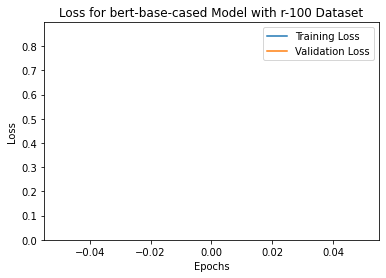

In [20]:
plt.plot(range(epochs), train_loss_vals, label='Training Loss')
plt.plot(range(epochs), eval_loss_vals, label='Validation Loss')

plt.title('Loss for ' + MODEL_CHECKPOINT + ' Model with ' + TARGET_CORPUS + ' Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, None)

plt.legend()

plt.savefig(OUTPUT_DIR + "train_valid_losses.png")

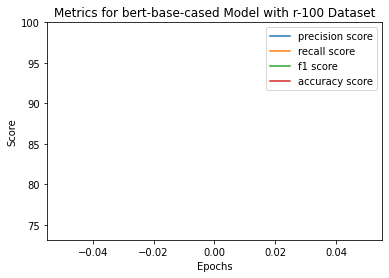

In [21]:
plt.clf()
for key in ["precision", "recall", "f1", "accuracy"]:
  plt.plot(range(epochs), overall_metrics[key], label = key + ' score')

plt.title('Metrics for ' + MODEL_CHECKPOINT + ' Model with ' + TARGET_CORPUS + ' Dataset')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.ylim(None, 100)

plt.legend()
plt.savefig(OUTPUT_DIR + "metrics.png")

In [22]:
_, predictions, true_vals = evaluate(eval_dl)

In [27]:
pred_vals = np.argmax(predictions, axis=1).flatten()

labeled_preds = [label_names[pred_val] for pred_val in pred_vals]
labeled_trues = [label_names[true_val] for true_val in true_vals]

directional_report = classification_report(labeled_trues, labeled_preds, output_dict=True)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
df = pd.DataFrame(directional_report).transpose()
df.to_csv(OUTPUT_DIR + 'directional_classification_report.csv')

In [29]:
pred_vals = np.argmax(predictions, axis=1).flatten()

labeled_preds = [label_names[pred_val].replace(":LR", "").replace(":RL", "") for pred_val in pred_vals]
labeled_trues = [label_names[true_val].replace(":LR", "").replace(":RL", "") for true_val in true_vals]

non_directional_report = classification_report(labeled_trues, labeled_preds, output_dict=True)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
df = pd.DataFrame(non_directional_report).transpose()
df.to_csv(OUTPUT_DIR + 'non_directional_classification_report.csv')